# Movie Recommendation using Boltzmann Machine

- Recommender 1 : Predict if a user will like a movie or not (1 or 0) - Using Bernoulli RBM (since we're just predicting a binary outcome) (Tut 10)
- Recommender 2 : Predict rating a user will provide to a move (from 1 to 5) - Using AutoEncoders (Tut 12)

In [1]:
# Installing pytorch
!pip install torch===1.5.1 torchvision===0.6.1 -f https://download.pytorch.org/whl/torch_stable.html
#!conda install -c pytorch pytorch
#!conda install pytorch torchvision cudatoolkit=10.2 -c pytorch

Looking in links: https://download.pytorch.org/whl/torch_stable.html


## Dowloading dataset

In [19]:
import requests, zipfile, io

def downloadData(zip_file_url):
    try:
        r = requests.get(zip_file_url, timeout=5)
        print(r.content)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall()
    except Exception as e:
        print(e)

#### ML-100K

In [20]:
## MovieLens 100K movie ratings Dataset - 100,000 ratings from 1000 users on 1700 movies.

# Linux cmds
'''
!wget "http://files.grouplens.org/datasets/movielens/ml-100k.zip"     # Download zip file from net
!unzip ml-100k.zip # Unzip file
!ls    # list directory 
'''

# Python way
downloadData("http://files.grouplens.org/datasets/movielens/ml-100k.zip")    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### ML-1M

In [21]:
## MovieLens 1M movie ratings Dataset - 1 million ratings from 6000 users on 4000 movies.

'''
This dataset contains more details about the movies which will help to design a more robust recommender system. 
Hence we download this as well.
'''


# Linux cmds
'''
!wget "https://grouplens.org/datasets/movielens/ml-1m.zip"     # Download zip file from net
!unzip ml-1m.zip # Unzip file
!ls    # list directory 
'''

#Python way
downloadData("http://files.grouplens.org/datasets/movielens/ml-1m.zip") 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Importing libraries

In [62]:
import numpy as np                     # to work with arrays
import pandas as pd                    # to import the dataset and create the training set and the test set
import torch                           # torch lib
import torch.nn as nn                  # to implement neural networks
import torch.nn.parallel               # for the parallel computations
import torch.optim as optim            # for the optimizer
import torch.utils.data                # tools that will be used
from torch.autograd import Variable    # for stochastic range and descent
from matplotlib import pyplot as plt

## Import Dataset

In [63]:
# movies.dat -> MovieID::Title::Genres
movies = pd.read_csv('./ml-1m/movies.dat',sep='::', header=None, engine='python', encoding='latin-1',
                    names=['MovieID','Movie Name','Genre'])
                    # there is no header row in the file -> header = None
                    # engine : {'c', 'python'} ->  Parser engine to use. The C engine is faster while the python engine is currently more feature-complete.
                    # encoding : utf-8 (default). here we have movie names with special chars. hence we change encoding to latin-1

# users.dat -> UserID::Gender::Age::Occupation::Zip-code            
users = pd.read_csv('ml-1m/users.dat',sep='::', header=None, engine='python', encoding='latin-1',
                   names=['UserID','Gender','Age','Occupation','Zip-code'])  

# ratings.dat -> UserID::MovieID::Rating::Timestamp
ratings = pd.read_csv('ml-1m/ratings.dat',sep='::', header=None, engine='python', encoding='latin-1',
                     names=['UserID','MovieID','Rating','Timestamp'])            

In [64]:
print(movies.head())
print("\n\n",users.head())
print("\n\n",ratings.head())

   MovieID                          Movie Name                         Genre
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy


    UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455


    UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291


## Prepare Training & Test Set

In [65]:
training_set = pd.read_csv('ml-100k/u1.base',delimiter='\t',header=None, names=['UserId','MovieId','Rating','Timestamp'])         
            # columns are separated by tabs. so here are separator is '\t'. Hence, Instead of sep, we use delimiter attribute.

test_set = pd.read_csv('ml-100k/u1.test',delimiter='\t',header=None, names=['UserId','MovieId','Rating','Timestamp'])             

In [66]:
# rows represent users, columns are 'User'
training_set.head()

,UserId,MovieId,Rating,Timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [67]:
'''
We will pass the dataset to pytorch. Hence converting the dataset to Array
'''

training_set = np.array(training_set, dtype='int')   
            # all the values in the dataset are int, so specifying that the array elements are of integer type
    
test_set = np.array(test_set, dtype='int')               

In [68]:
training_set

array([[        1,         1,         5, 874965758],
       [        1,         2,         3, 876893171],
       [        1,         3,         4, 878542960],
       ...,
       [      943,      1188,         3, 888640250],
       [      943,      1228,         3, 888640275],
       [      943,      1330,         3, 888692465]])

### Getting the number of users and movies

In [69]:
'''
Convert the training & test set into a matrix where the lines/rows are represented by users, columns are going to be 
movies, and the cells will be the ratings.

Matrix Format: 

        Movie1   Movie2   Movie3 ...   MovieM
User 1    r11      r12     r13           r1M
User 2    r21      r22     r23           r2M  
User 3    r31      r32     r33           r3M  
:
User N    rN1      rN2     rN3           rNM  

For this we have to find total no of users (N) & movies (M). (Both training & test set will have the same no. of users & movies)

'''
## Getting no. of users & movies
'''
nb_users = max(pd.read_csv('ml-100k/u.user',header=None,sep='|')[:][0])
nb_movies = max(pd.read_csv('ml-100k/u.item',header=None,sep='|',  encoding='latin-1')[:][0])
'''
# OR
nb_users = int(max(max(training_set[:,0]),max(test_set[:,0])))
nb_movies = int(max(max(training_set[:,1]),max(test_set[:,1])))

nb_users, nb_movies

(943, 1682)

### Convert data in array with users as rows & columns as movies

In [70]:
def convert(data):
    """
    Here we create a list of lists. i.e the parent list index will represent users & sub list will denote ratings of movies.
    If user didn't rate a movie, we will set it to 0.
    
    So the whole list of lists will be a list of 943 lists because we have 943 users, and each of these 943 lists 
    will be a list of 1,682 elements because we have 1,682 movies.
    Size of test & training set will be same as we are considering all users & all movies.
    Also, we remove timestamp column as its not required
    """
    new_data = []
    
    for user_id in range(1,nb_users+1):
        movies_id = data[:,1][data[:,0]== user_id]  # Get all movies list user rated
        m_ratings = data[:,2][data[:,0]== user_id]  # Get all movies ratings provided by a user
        
        u_ratings = np.zeros(nb_movies)    # Create a list with 0 values & length = no. of movies
        
        #print(len(movies_id),"--", len(m_ratings),"--", len(u_ratings))
        u_ratings[movies_id-1] = m_ratings  # Assign ratings value to the movie in sub list
        
        new_data.append(list(u_ratings))
    
    return new_data
        

training_set = convert(training_set)  # Convert training_set into desired array/matrix format
test_set = convert(test_set)          # Convert test_set into desired array/matrix format
    

In [71]:
len(training_set)

943

### Convert data into pytorch tensors/array

In [72]:
'''
Tensors are simply arrays that contain elements of a single data type.
So a tensor is a multi-dimensional matrix but instead of being a NumPy array, this is a PyTorch array.

NumPy arrays are less efficient than the tensors
With TensorFlow also we work with tensors that are TensorFlow tensors, another kind of tensor/multi-dimensional matrix,
using which we could also implement our autoencoders from scratch.

But it turned out that, for autoencoders, Pytorch was more preferrable as we not only get better results, but also 
this was much more simple.

Here we have two separate multi-dimensional matrices based on PyTorch. 
Training set is going to be one torch.Tensor and the test set is going to be another torch.Tensor.

'''
# create an object of class. torch.Tensor 
training_set = torch.FloatTensor(training_set)  # FloatTensor(list_of_list) class creates a multi dimensional array/matrix with element data type as float
test_set = torch.FloatTensor(test_set)

### Convert the ratings into binary ratings 1 (Liked/yes) or 0 (Not Liked/No)

In [73]:
''' 
With restricted Boltzmann machines, we can predict if a user likes a movie - yes or no.
So we have to convert all the ratings into binary ratings, zero or one, as these are gonna be the inputs of our 
restricted Boltzmann machines.

Then using Autoencoders, we will predict the exact ratings given by the users to a movie.
'''

def returnBinaryRating(tensorMatrix):
    # Replace all 0 by -1 to denote no rating was provided
    tensorMatrix[tensorMatrix==0] = -1
    
    # Replace all ratings with values 1 & 2 to 0 to denote dislike
    tensorMatrix[tensorMatrix==1] = 0
    tensorMatrix[tensorMatrix==2] = 0
    
    # Replace all ratings with values greater than 2 to 1 to denote like
    tensorMatrix[tensorMatrix >= 3] = 1
    
    return tensorMatrix

training_set = returnBinaryRating(training_set)
test_set = returnBinaryRating(test_set)

In [74]:
training_set

tensor([[ 1.,  1.,  1.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1.,  1., -1.,  ..., -1., -1., -1.]])

## Preparing the Model - Create the architecture of the Neural Network (RBM)

In [75]:
## Creating architecture of Neural Network (RBM)
'''
A restricted Boltzmann machine is a probability graphical model.

Parameters to be set to initialize the RBM are:
    1) number of hidden notes,
    2) weights for the probability of the visible note, given the hidden note.
    3) the bias for the same probability
    4) the bias for the probability of the visible note given the hidden note.

Thus we create a class with 3 functions.
 - function __init__ to initialize the RBM by initializing its parameters
 - function to sample H i.e. the probabilities of the hidden nodes given the visible nodes
 - function to sample V i.e. the probabilities of the visible nodes given the hidden nodes.
 
 Here One visible node represents one movie & V is a vector of all movie ratings for a user.
'''
class RBM():
    def __init__(self, nv:int, nh:int):
        """
        Initialize the RBM paramters that we will be optimized during the training of the RBM i.e. the weights and the bias
        Input Parameters: 
            nv -> no. of visible nodes
            nh -> no. of hidden nodes            
        """
        # Initialize all the weights in a torched tensor. 
        # These weights are all the parameters of the probabilities of the visible nodes given the hidden nodes.
        # randn(size) Returns a tensor filled with random numbers from a normal distribution with mean `0` and variance `1` (also called the standard normal distribution).
        self.W = torch.randn(nh,nv)
                 
        # Initialize bias as a 2D tensor - first dimension corresponds to the batch & the second corresponds to the bias.
        # here batch size =1 & no. of bias values for hidden nodes = nh or no. of visible nodes = nv                          
        '''
        Why do we need to create this fake dimension for the batch? 
            It's because the functions that we're gonna use in PyTorch cannot accept a single input vector
            of one dimension as argument, but a two dimensional tensor with the first dimension corresponding to the 
            batch and the second dimension corresponding to the bias.
        '''
        self.a = torch.randn(1, nh)  # Define the bias for the probabilities of the hidden nodes given the visible nodes.
        self.b = torch.randn(1, nv)  # Bias for the visible node
        
    
    def sample_h(self, x):
        """
        The second function is about sampling the hidden nodes according to the probabilities, Ph given v
        where h is a hidden node and v is a visible node.

        This probability Ph given v, is basically the sigmoid activation function.
        
        Why do we need this sample h function?
            Because during the training we will approximate the log likelihood gradient through Gibbs sampling.
            To apply Gibbs sampling, we need to compute the probabilities of the hidden nodes given the visible nodes.
            And then once we have this probability, we can sample the activations of the hidden nodes.
    
        Input:
            x --> list of visible neurons v, in the probabilities, Ph given v. 
        Output: samples of the different hidden nodes of our RBM, according to the probabilities
        """

        # matrix multiplication (input * wt transpose)
        wx = torch.mm(x, self.W.t())  
                
        # Here we expand bias as wx (by adding a new dimension to the bias) to ensure that the bias are applied to each line of the mini batch.
        activation = wx + self.a.expand_as(wx)  
                
        '''
        Remember that each input vector will not be treated individually, but inside batches.
        
        Even if the batch contains one input vector or one vector of bias, that input vector is still in the batch.
        This is called a mini batch.

        And here when we add the bias of the hidden nodes, we want to make sure that this bias is applied to each 
        line of the mini batch i.e. to each line of this dimension.
        To ensure this, we use a function 'expand_as()' that will again add a new dimension for these bias that we're 
        adding.

        The activation function (that activates the hidden node) is a linear combinations of the visible 
        neurons (x), where the coefficients are the weights to which the bias is added.
        
        This activation function represents a probability that the hidden node is activated according to the value
        of the visible node. --> P_h_given_v.
        '''
        
        # Find probability that the hidden node is activated according to the value of the visible node
        P_h_given_v = torch.sigmoid(activation)  # P_h_given_v is a vector of nh elements
        
        '''
        Say we have a hidden node (h) that detects a feature 'the movie belongs to drama genre'. So for all those visible 
        nodes/users (v) who love drama movie, value of P-h_given_v for these users will be high.
        '''
        
        # Return : 1) all the ratings i.e. probabilities of the hidden neurons, given the values of the visible nodes.
        #          2) Bernoulli sampling of the hidden neurons.
        '''
        torch.bernoulli(probability_vector) : Draws binary random numbers (0 or 1) from a Bernoulli distribution.
                i.e. if probability = 0.7, then a random no. is drawn between 0 & 1 and if this random no.
                is greater than the probability (0.7) then return 1 else return 0.
        '''
        return P_h_given_v , torch.bernoulli(P_h_given_v)

     
    def sample_v(self, y):
        """
        This function is about sampling the visible nodes according to the probabilities, Pv given h
        where h is a hidden node and v is a visible node.

        This probability Pv given h, is basically the sigmoid activation function.
        
        Why do we need this sample h function?
            Because during the training we will approximate the log likelihood gradient through Gibbs sampling.
            To apply Gibbs sampling, we need to compute the probabilities of the hidden nodes given the visible nodes.
            And then once we have this probability, we can sample the activations of the hidden nodes.
    
        Input:
            y --> list of hidden neurons h, in the probabilities, Pv given h.
        Output: samples of the different visible nodes of our RBM, according to the probabilities
        """

        '''
        nV = no. of movies = no. of visible nodes = no. of probabilities of v given h (P_v_given_h)
        '''
        
        # matrix multiplication (input * w)  --- here we don't transpose W
        wy = torch.mm(y, self.W)  
                
        # Here we expand bias as wx (by adding a new dimension to the bias) to ensure that the bias are applied to each line of the mini batch.
        activation = wy + self.b.expand_as(wy)  
        
        # Find probability that the hidden node is activated according to the value of the visible node
        P_v_given_h = torch.sigmoid(activation)  # P_v_given_h is a vector of nh elements
        
        return P_v_given_h , torch.bernoulli(P_v_given_h)

    
    def train(self, v0, vk, Ph0, Phk):
        # Perform Contrastive divergence with Gibbs sampling.
        """
        This function is about the contrastive divergence that we will use to approximate the likelihood gradient.
        
        Since, RBM is an energy-based model, we have this energy function that we try to minimize.
        And since this energy function depends on the weight of the model(weights in this tensor of weights),
        we need to optimize these weights to minimize the energy.
        
        RBM can also be seen as a probability graphical model. In that case, the goal (equivalent to minimizing the energy)
        is to maximize the log-likelihood of the training set for which we need to compute the gradient.
        
        So here we minimize a loss function and through stochastic gradient descent update the weights in the direction 
        of this minimum loss.
        But here the gradient computations are too heavy to be calculated directly, so we approximate these gradients,
        by using the contrastive divergence algorithm (which comes with Gibbs Sampling).
        Gibbs sampling consists of creating Gibbs chain in k-steps and this Gibb chain in created exactly by sampling 
        K times the hidden nodes and the visible node.
        
        CD-k algorithm:-
        1st Iteration : We start with our input vector Vo, then based on the probabilities P_H_given_Vo, we sample 
        the first set of nodes.
        2nd Iteration : Then we take these sampled hidden nodes as input (H1), to sample the visible nodes with 
        the probabilities P_V_given_H1.
        3rd Iteration : Then again we use these sample visibile nodes (V1), to sample again the hidden nodes with the
        probabilities P_H_given_V1.
        kth Iteration : Then again we sample the visible nodes & then sample the hidden nodes. We do this K times.

        So in this training function, we perform 3 tasks:
        1. update the tensor of weights - W
        2. update bias b (bias of P_V_given_H)
        3. update bias a (bias of P_H_given_V).
        
        Input:
        - Vo : Input vector containing the ratings of all the movies by one user (input vector of observations)
        - Vk : Visible nodes obtained after K samplings/iterations/contrastive divergence.
        - Ph0 : Vector of probabilities that at the first iteration the hidden nodes equal one given the values of Vo.
        - Phk : Vector of probabilities of the hidden nodes after K sampling given the values of the visible nodes Vk
        """
        
        # Update Weights
        self.W += (torch.mm(v0.t(), Ph0) - torch.mm(vk.t(), Phk)).t()
        
        # Update Bias        
        self.b += torch.sum((v0 - vk),0)   # torch.sum() -> adds difference between the input vector of observations & the
                                           # visibile nodes after K samplings to 0, to keep the dimensionality of bias as 2
        self.a += torch.sum((Ph0 - Phk),0)  
        

![CD-k steps](CD-kSteps.png)

## Use the RBM model to perform rating prediction

In [110]:
class DL_Task():
    rbm = None
    #batch_size = nb_epoch = k_steps = 0
    
    ### Define an object of the RBM class/model
    def create_model(self, nh:int) -> RBM:
        '''
        Input: Hyperparameters
        nh = no. of hidden nodes = no. of features we want to detect

        '''
        ## Define no. of visible nodes. 
        '''
        One visible node represents one movie. So no. of visible nodes = no. of movies  
        '''
        #nv = nb_movies
        # OR
        nv = len(training_set[0])  # No. of columns in 1st line of training set

        ## Define no. of hidden nodes - We can tune our mode by adjusting this parameter
        '''
        We can choose any no. of hidden nodes. 
        no. of hidden nodes = no. of features we want to detect
        '''
        #nh = 100     


        ## Create an object of the RBM class/model
        self.rbm = RBM(nv, nh)

        #return rbm
    
    ### Training the RBM
    def fit(self, batch_size:int ,nb_epoch:int, k_steps:int):

        ## Batch size - We can tune our mode by adjusting this hyperparameter 
        '''
        batch_size = 1 implies 'ONLINE LEAARNING' i.e. after each observation, we will update the weights. 
        (So no. of batch = no. of users/records/samples/input vectors/observations as each batch will have 1 record )

        We want to speead up the training so we take a large batch size. So when we train our algorithm, we will update the 
        weights after several observations that will all go into a batch. 
        The batches will have the same number of observations (btach_size).
        no_of_batches = total_no_of_records/batch_size
        '''
        #batch_size = 100 


        # Define no. of epochs
        '''
        number of epochs = number of complete passes through the training dataset.
        One epoch will involve all 'n' batches i.e. 'n' updates to the model.
        With say 'x' epochs, the model will be exposed to or pass through the whole dataset 'x' times. 
        That is a total of x*n batches during the entire training process.
        '''
        #nb_epoch = 10 

        # Loop through the epoch
        for epoch in range(1,nb_epoch+1):

            # Intialize the loss
            train_loss = 0         # Loss will increase as we find some errors between the predictions and the real ratings

            # We need a counter (of type float) to Normalize the loss( by dividing the loss with the counter)
            counter = 0.           # Counter will increament after each epoch

            # Loop through the batch
            for user_id in range(0, nb_users-batch_size, batch_size):
                # Define Input & Target Vector. 
                '''
                Input will change with Gibbs sampling but target will remain same.
                Input & target vector (visible node values) is the ratings of all the movies by the specific user 
                '''
                vk = training_set[user_id:user_id+batch_size]    # Input Vector consists of all observations in a batch.
                v0 = training_set[user_id:user_id+batch_size]    # Target Vector 

                # Get the Initial Probabilities
                '''
                ph0 = probability that the hidden node at the start equal one given the real ratings i.e. ratings of the movies 
                      that were already rated by the users of our batch.
                '''
                ph0,_ = self.rbm.sample_h(v0)   # Here we want only the probabilities & not hidden node values from the function

                # For loop for the k steps of contrastive divergence
                #k_steps = 10                # This parameter can also be tuned
                for k in range(k_steps):
                    # Given the visible nodes, we calculate the hidden nodes
                    _, hk = self.rbm.sample_h(vk)                # Here we just want the hidden node values & not the probabilities

                    # Now using the hidden nodes find the value of visible nodes
                    _, vk = self.rbm.sample_v(hk)

                    # Reverse the values of non-rated movies
                    '''
                    Its important to note that we don't wanna learn where there is no rating, that is for the sales 
                    that have a -1 ratings, we do not include these sales in the training process. So we'll freeze these visible 
                    nodes that contain the -1 ratings i.e we won't update them during Gibbs sampling.
                    '''
                    vk[v0<0] = v0[v0<0]

                # Find the probability of hidden nodes given the last sample of the visible nodes.
                phk,_ = self.rbm.sample_h(vk)

                # For each batch, using vk, we can approximate the gradient to update the weights & bias
                self.rbm.train(v0,vk,ph0,phk)

                # Find the training loss
                '''
                Add error (i.e. difference between the predictive ratings and the real/original ratings of our target, v0) 
                to the training loss.        
                '''
                train_loss += self.loss_calc(vk,v0)
                counter += 1.

            # Print how the model is performing in each epoch
            print("epoch : "+str(epoch)+" \t loss :"+str(train_loss/counter))  # here training loss is less than 25% which is good
        
    
    ### Testing the RBM  
    def predict(self):

        # Intialize the loss
        test_loss = 0         # Loss will increase as we find some errors between the predictions and the real ratings

        # We need a counter (of type float) to Normalize the loss( by dividing the loss with the counter)
        counter = 0.           # Counter will increament after each epoch

        # Finding accuracy
        test_accuracy = 0.

        # Loop through the test set
        for user_id in range(nb_users):
            # Define Input & Target Vector. 
            '''
            Input will change with Gibbs sampling but target will remain same.
            Input & target vector (visible node values) is the ratings of all the movies by the specific user 

            Now, we are dealing with the test set & trying to predict the ratings in the test set
            On input v we will make the prediction.
            Target vt, contains the original ratings of the test set, so that is what we will compare to our predictions in the end.

            For vt, We need to take the observations from the test set because we want to compare the real ratings of the test 
            set to our predictions.

            But for the input v, we take the observations from the training set, because the training set is the input that 
            will be used to activate the hidden neurons to get the output. The training set contains the ratings of the training 
            set and it doesn't contain the answers of the test set.
            By using the inputs of the training set we will activate the neurons of our RBM to predict the ratings of the movies
            that were not rated yet, and that is the ratings of the test set.   .
            '''
            v = training_set[user_id:user_id+1] # Input Vector consists of 1 record with some values required to activate the neurons
            vt = test_set[user_id:user_id+1]    # Target Vector consists of 1 record with expected rating values

            # Ignore the non-rated movies in the test set
            if (len(vt[vt>=0])>0):    

                # Given the dummy visible nodes, we calculate the hidden nodes
                _, h = self.rbm.sample_h(v)        # Here we just want the hidden node values & not the probabilities

                # Now using the hidden nodes predict the values of visible nodes
                _, v = self.rbm.sample_v(h)

                # Find the test loss
                '''
                Add error (i.e. difference between the predictive ratings and the real/original ratings of our target, v0) 
                to the loss function error.
                We can use either RMAC error function or the distance error function.
                Here we use the simple distance function which calculates absolute values between the prediction & the real rating.

                Also, we ignore the movies that have not been rated in the test set
                '''
                test_loss += self.loss_calc(v,vt)    # Difference between expected & predicted values
                test_accuracy += self.accuracy_calc(v,vt)   
                #print(test_loss,":",test_accuracy,":",counter)
                counter += 1.

        # Print how the model is performing in each epoch
        print("test loss : "+str(test_loss/counter), "\t accuracy :",str(test_accuracy/counter)) 
        
        return test_loss/counter, test_accuracy/counter
        
        
    # Define Loss function
    def loss_calc(self,v_pred, v_target):
        # there are two ways of evaluating our RBM - with the RMSE and the Average Distance.
        # Both take Difference between expected & predicted values

        # Method 1: Average Distance
        '''
        Here we use the simple distance function which calculates absolute difference values between the prediction & the 
        real rating.
        Also, we ignore the movies that have not been rated in the test/training set
        '''
        return torch.mean(torch.abs(v_target[v_target>=0]-v_pred[v_target>=0])) 

        # Method 2: RMSE
        '''
        The RMSE (Root Mean Squared Error) is calculated as the root of the mean of the squared differences between 
        the predictions and the targets.
        Also, we ignore the movies that have not been rated in the test/training set
        '''
        #return np.sqrt(torch.mean((v_target[v_target>=0]-v_pred[v_target>=0])**2))  

    
    # Define accuracy function
    def accuracy_calc(self, v_pred, v_target):
        # Method 1: Average Distance
        '''
        Here we use the simple distance function which calculates absolute difference values between the prediction & the 
        real rating.
        Also, we ignore the movies that have not been rated in the test/training set
        '''
        #print(sum(v_target[v_target>=0]==v_pred[v_target>=0]) )
        return sum(v_target[v_target>=0]==v_pred[v_target>=0])/float(len(v_target[v_target>=0]))

In [107]:
model = DL_Task()
model.create_model(nh=100)  # No. of hidden nodes = 100
model.fit(batch_size=100 ,nb_epoch=10, k_steps=10)
model.predict()

epoch : 1 	 loss :tensor(0.3579)
epoch : 2 	 loss :tensor(0.2492)
epoch : 3 	 loss :tensor(0.2480)
epoch : 4 	 loss :tensor(0.2508)
epoch : 5 	 loss :tensor(0.2485)
epoch : 6 	 loss :tensor(0.2471)
epoch : 7 	 loss :tensor(0.2484)
epoch : 8 	 loss :tensor(0.2508)
epoch : 9 	 loss :tensor(0.2462)
epoch : 10 	 loss :tensor(0.2506)
test loss : tensor(0.2458) 	 accuracy : tensor(0.7542)


Using the RMSE, our RBM would obtain an error around 0.46. But be careful, although it looks similar, one must not confuse the RMSE and the Average Distance. A RMSE of 0.46 doesn’t mean that the average distance between the prediction and the ground truth is 0.46. In random mode we would end up with a RMSE around 0.72. An error of 0.46 corresponds to 75% of successful prediction.
<br><br>
Using Average Distance error metric, we geta loss of 0.24, which is equivalent to about 75% of correct prediction.

In [108]:
# If you want to check that 0.25 corresponds to 75% of success, you can run the following test:

u = np.random.choice([0,1], 1000)    # Generates a random sample from a given 1-D array
v = np.random.choice([0,1], 1000)
#print(u,"--",v,"--",sum(u==v))
u[:500] = v[:500]                 # Making atleast 50% of the values same
#print(sum(u==v))
print(sum(u==v)/float(len(u))) # -> you get 0.75   
print(np.mean(np.abs(u-v))) # -> you get 0.25

# so 0.25 corresponds to 75% of success.

0.758
0.242


## Hyper parameter tuning
In deeplearning, hyper-parameters are: learning rate, batch size, momentum, and weight decay. 
In BMM, k-step is also a hyper parameter

In [126]:
def plot_graph(x,error,accuracy,xlabel):
        
    # Plot the graph
    plt.plot(x, error, 'bx-') 
    plt.plot(x, [x-0.5 for x in accuracy], 'ro-') 
    plt.xlabel(xlabel) 
    #plt.ylabel('') 
    plt.title('Error & Accuracy Plot')
    plt.legend(('Error','Accuracy'))
    plt.show()  
    

epoch : 1 	 loss :tensor(0.2917)
epoch : 2 	 loss :tensor(0.2534)
test loss : tensor(0.2400) 	 accuracy : tensor(0.7600)
epoch : 1 	 loss :tensor(0.3253)
epoch : 2 	 loss :tensor(0.2482)
test loss : tensor(0.2620) 	 accuracy : tensor(0.7380)
epoch : 1 	 loss :tensor(0.3508)
epoch : 2 	 loss :tensor(0.2479)
test loss : tensor(0.2485) 	 accuracy : tensor(0.7515)
epoch : 1 	 loss :tensor(0.3270)
epoch : 2 	 loss :tensor(0.2321)
test loss : tensor(0.2521) 	 accuracy : tensor(0.7479)
epoch : 1 	 loss :tensor(0.3364)
epoch : 2 	 loss :tensor(0.2379)
test loss : tensor(0.2484) 	 accuracy : tensor(0.7516)
epoch : 1 	 loss :tensor(0.3757)
epoch : 2 	 loss :tensor(0.2551)
test loss : tensor(0.2367) 	 accuracy : tensor(0.7633)
epoch : 1 	 loss :tensor(0.3610)
epoch : 2 	 loss :tensor(0.2498)
test loss : tensor(0.2526) 	 accuracy : tensor(0.7474)
epoch : 1 	 loss :tensor(0.3581)
epoch : 2 	 loss :tensor(0.2503)
test loss : tensor(0.2502) 	 accuracy : tensor(0.7498)
epoch : 1 	 loss :tensor(0.3614)

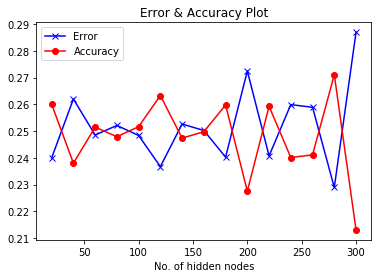

In [124]:
# Check suitable no. of hidden nodes
model = DL_Task()

no_of_hidden_nodes = range(20,310,20)
error=[]
accuracy = []

for h in no_of_hidden_nodes:
    model.create_model(h)
    model.fit(batch_size=100 ,nb_epoch=2, k_steps=7)
    err, acc = model.predict()
    error.append(err)
    accuracy.append(acc)
    
plot_graph(no_of_hidden_nodes, error, accuracy, 'No. of hidden nodes')

epoch : 1 	 loss :tensor(0.3300)
epoch : 2 	 loss :tensor(0.2489)
test loss : tensor(0.2509) 	 accuracy : tensor(0.7491)
epoch : 1 	 loss :tensor(0.2511)
epoch : 2 	 loss :tensor(0.2451)
test loss : tensor(0.2429) 	 accuracy : tensor(0.7571)
epoch : 1 	 loss :tensor(0.2518)
epoch : 2 	 loss :tensor(0.2483)
test loss : tensor(0.2578) 	 accuracy : tensor(0.7422)
epoch : 1 	 loss :tensor(0.2466)
epoch : 2 	 loss :tensor(0.2449)
test loss : tensor(0.2311) 	 accuracy : tensor(0.7689)
epoch : 1 	 loss :tensor(0.2485)
epoch : 2 	 loss :tensor(0.2485)
test loss : tensor(0.2559) 	 accuracy : tensor(0.7441)
epoch : 1 	 loss :tensor(0.2491)
epoch : 2 	 loss :tensor(0.2462)
test loss : tensor(0.2428) 	 accuracy : tensor(0.7572)
epoch : 1 	 loss :tensor(0.2467)
epoch : 2 	 loss :tensor(0.2476)
test loss : tensor(0.2511) 	 accuracy : tensor(0.7489)
epoch : 1 	 loss :tensor(0.2484)
epoch : 2 	 loss :tensor(0.2491)
test loss : tensor(0.2468) 	 accuracy : tensor(0.7532)
epoch : 1 	 loss :tensor(0.2460)

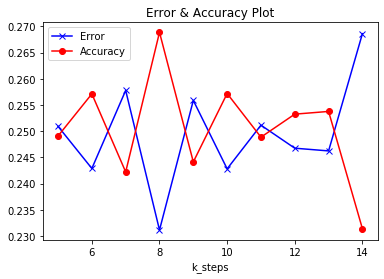

In [128]:
# Plot k-steps 

model = DL_Task()
model.create_model(nh=100)  # No. of hidden nodes = 100

k_step = range(5,15)
error = []
accuracy = []

for k in k_step:
    model.fit(batch_size=100 ,nb_epoch=2, k_steps=k)
    err, acc = model.predict()
    error.append(err)
    accuracy.append(acc)

# Plot the graph
plot_graph(k_step, error, accuracy, 'k_steps')

# Graph shows k_steps = 8 is suitable